In [1]:
from keras import backend as K
from keras.models import Model
from keras.models import Sequential
from keras.layers import Input, Activation, Add, Conv1D, MaxPooling1D, Dropout, Dense, Flatten
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.utils import np_utils
from keras.regularizers import l2
from keras.utils.generic_utils import get_custom_objects
from keras.backend import sigmoid

K.clear_session()

kernel_size_ = 5
filters_ = 100

inp = Input(shape=(238,21))
C = Conv1D(filters=filters_, kernel_size=kernel_size_, strides=1)(inp)

C11 = Conv1D(filters=filters_, kernel_size=kernel_size_, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=filters_, kernel_size=kernel_size_, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=kernel_size_, strides=1)(A12)

C21 = Conv1D(filters=filters_, kernel_size=kernel_size_, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=filters_, kernel_size=kernel_size_, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S21)
M21 = MaxPooling1D(pool_size=filters_, strides=1)(A22)

C31 = Conv1D(filters=filters_, kernel_size=kernel_size_, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=filters_, kernel_size=kernel_size_, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=filters_, strides=1)(A32)

F1 = Flatten()(M31)
D1 = Dense(500, activation = 'relu')(F1)
DR = Dropout(0.15)(D1)
D2 = Dense(1,activation = 'linear')(DR)
model = Model(inputs=inp, outputs=D2)

print(model.summary())

import math 
from scipy import stats
from keras import callbacks
import tensorflow as tf
import matplotlib.pyplot as plt
        
def pearson_r(y_true, y_pred):
    x = y_true
    y = y_pred
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    r_num = K.sum(xm * ym)
    x_square_sum = K.sum(xm * xm)
    y_square_sum = K.sum(ym * ym)
    r_den = K.sqrt(x_square_sum * y_square_sum)
    r = r_num / r_den
    return K.mean(r)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 238, 21)]    0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 234, 100)     10600       ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 234, 100)     50100       ['conv1d[0][0]']                 
                                                                                                  
 activation (Activation)        (None, 234, 100)     0           ['conv1d_1[0][0]']               
                                                                                              

2022-09-12 11:50:29.450571: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None


In [2]:
from keras.models import load_model

model.load_weights('models/gfp_cnn.hdf5') 

In [3]:
import numpy as np
import math
import random
from sklearn.preprocessing import OneHotEncoder
from IPython.core.display import HTML

def print_seq(seq):
    res_dict = {'A':'798953', 'C':'455E45', 'D':'FF7042', 'E':'FF8CFF', 'F':'B84C00',
            'G':'4747B8', 'H':'A00042', 'I':'004C00', 'K':'FF7C70', 'L':'660000',
            'M':'525252', 'N':'00007C', 'P':'534C42', 'Q':'FF4C4C', 'R':'8C704C',
            'S':'7070FF', 'T':'15C9A5', 'V':'B8A042', 'W':'4F4600', 'Y':'FF00FF',
            'Z':'A0A0FF'}
    
    source = '<TT>'
    for i, a in enumerate(seq):
        source += "<span style='color: #{0}'>{1}</span>".format(res_dict[a], a)
        if (i+1)%10 == 0:
            source += '&nbsp;'
        if (i+1)%100 == 0:
            source += '</br>'
    source+='</TT>'
    display(HTML(source))

def prepare_sequences(wt,seq_number=100):
    seq_list = [mutate(wt, 0.7) for a in range(seq_number-1)] 
    seq_list.append(wt)
    return seq_list

def fitness_function(model, individuals):
    categories_ = ['A','C','D','E','F','G','H',
                   'I','K','L','M','N','P','Q',
                   'R','S','T','V','W','Y','Z']

    encoder = OneHotEncoder(categories = [categories_])
    individuals = list(map(lambda x: encoder.fit_transform(np.array(list(x)).reshape(-1, 1)).toarray(), 
                           individuals))
    individuals = np.array(individuals)
    fs = model.predict(individuals)
    fs = fs.flatten()
    return fs

def mutate(seq, max_mut_rate=0.3):
    seq = list(seq)
    residues = 'ACDEFGHIKLMNPQRSTVWY'
    mut_count = random.randint(1,math.ceil(len(seq)*max_mut_rate))
    for a in range(mut_count):
        pos = random.randint(0,len(seq)-1)
        seq[pos] = random.choice(residues.replace(seq[pos],''))
    return ''.join(seq)
    
def selection(inds, idx, best):
    probs = [a/sum(idx) for a in idx]
    inds_probs = sorted(list(zip(inds, probs)), key=lambda tup: tup[1], reverse = True)
    next_gen = [a[0] for a in inds_probs[:best]]
    off_idx = [np.random.choice(range(len(inds)), p=probs) for a in range(int(len(inds)**0.5)-best)]
    next_gen.extend([inds[a] for a in off_idx])
    return np.array(next_gen)

def merge(gen):
    next_gen = []
    for i_,i in enumerate(gen):
        for j_,j in enumerate(gen):
            fl = 0
            merge_prod = []
            for a in range(len(gen[i_])):
                if fl==0:
                    merge_prod.append(gen[i_][a])
                    fl=1
                else:
                    merge_prod.append(gen[j_][a])
                    fl=0
            next_gen.append(''.join(merge_prod))
    return np.array(next_gen)

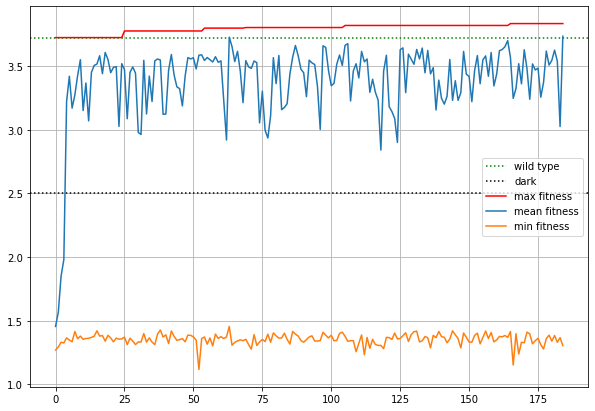

MSKGEELFTGVVPILVELDGDVNGHKFSVFGEGEGDATNGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYSLHNVYIMADKQKNGIKANFKTRHNIEDGSVQLADHYQQNTPIGDGPRLLPDNHYLSTQQALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN


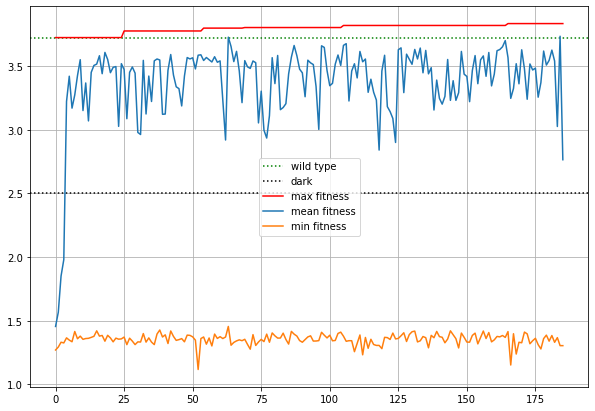

MSKGEELFTGVVPILVELDGDVNGHKFSVFGEGEGDATNGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYSLHNVYIMADKQKNGIKANFKTRHNIEDGSVQLADHYQQNTPIGDGPRLLPDNHYLSTQQALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN


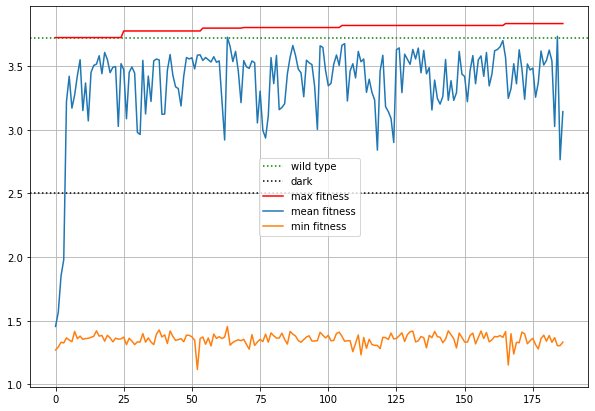

MSKGEELFTGVVPILVELDQDVNGHKFSVFGEGEGDATNGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPLGYVQERTIFGKDDGNYKTRAEVKFEGDTLVNRIELKGEDFKEDGNILGHKLEYNYSEHNVYIMADKQCNGIKARFKTRHGIEDGSVQLADHYQQNTPIGDGPRLLPDNNYLSTQQALSKDPNEKRMHMVLLEFVTAAGITHGMDELYN


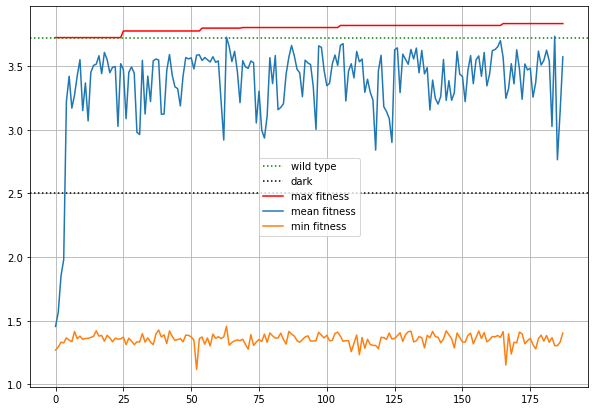

MSKGEELFTGVVPILVELDGDVNGHKFSVFGEGEGDATNGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYSLHNVYIMADKQKNGIKANFKTRHNIEDGSVQLADHYQQNTPIGDGPRLLPDNHYLSTQQALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN


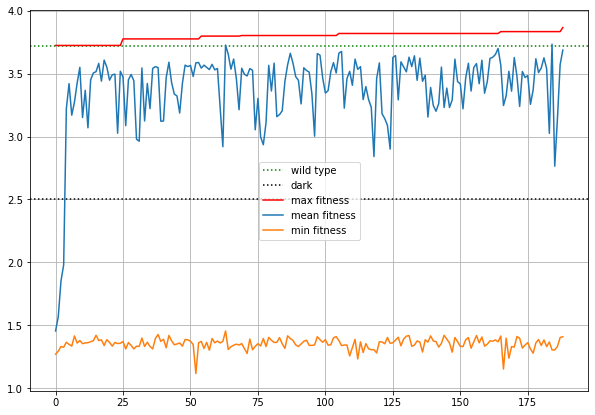

MSKGEELFTGVVPILVELDGDVNGHKFSVFGEGEGDATNGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYSRHNVYIMADKQKNGIKANFKTRHNIEDGSVQLADHYQQNTPIGDGPRLLPDNHYLSTQQALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN


In [6]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

wt = 'MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKRHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKTRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYN'

seq_list = prepare_sequences(wt, 100)

hs = []
ms = []
min_s = []
for a in range(10000):
    fs = fitness_function(model, seq_list)
    '''
    print('Generation: '+str(a))
    for it in sorted(list(zip(seq_list, fs)), key=lambda tup: tup[1], reverse = True)[:1]:
        print(it[1])
        print_seq(it[0])
        print(' ')
    print('----------------------------------')
    '''
    
    hs.append(sum(fs)/len(fs))
    ms.append(max(fs))
    min_s.append(min(fs))
    next_gen = selection(seq_list, fs, 3)
    next_gen = merge(next_gen)
    '''
    print('Max: {0}, Avg: {1}, Min: {2}'.format(max(fs), sum(fs)/len(fs), min(fs)))
    '''
    
    for n in range(len(next_gen)):
        if np.random.randint(100)<=10:
            next_gen[n] = mutate(next_gen[n], 0.1)
            
    seq_list = next_gen
    
    clear_output(wait=True)
    plt.figure(figsize = (10,7))
    plt.grid(True)
    plt.axhline(y=3.719, label = 'wild type', color='g', linestyle='dotted')
    plt.axhline(y=2.5,   label = 'dark', color='black', linestyle='dotted')
    plt.plot(ms, label = 'max fitness', color = 'r')
    plt.plot(hs, label = 'mean fitness')
    plt.plot(min_s, label = 'min fitness')
    plt.legend(loc = 'best')
    plt.show()
    print(seq_list[0])
    